### Library Imports 

In [4]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

In [5]:
import pymc as pm
import pymc.sampling_jax

In [6]:
# Matplotlib and seaborn for visualizations
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.pylabtools import figsize
import matplotlib.lines as mlines

import seaborn as sns

import arviz as az

# Standard machine learning models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Scikit-learn utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, auc

import itertools

pd.options.mode.chained_assignment = None

import matplotlib as mpl

from warnings import filterwarnings
filterwarnings('ignore')
import pickle

### Defining functions

In [7]:
def plot_mean_roc(y_true, posterior_samples, title='Mean ROC curve with 95% CI'):
    fpr_grid = np.linspace(0, 1, 64)
    tpr_interpolated = []
    aucs = []
    
    
    for i in range(posterior_samples.shape[1]):
        y_scores = posterior_samples[i]
        fpr, tpr, _ = roc_curve(y, y_scores)
        tpr_interpolated.append(np.interp(fpr_grid, fpr, tpr))
        aucs.append(auc(fpr, tpr))
    
    # Convertir en array numpy pour faciliter les calculs
    tpr_interpolated = np.array(tpr_interpolated)
    
    # Calculer la TPR moyenne et son intervalle de confiance à 95%
    mean_tpr = tpr_interpolated.mean(axis=0)
    std_tpr = tpr_interpolated.std(axis=0)
    ci_lower = np.percentile(tpr_interpolated, 2.5, axis=0)
    ci_upper = np.percentile(tpr_interpolated, 97.5, axis=0)
    
    # Calculer la moyenne des AUC
    mean_auc = np.mean(aucs)
    lower_auc = np.percentile(aucs, 2.5)
    upper_auc = np.percentile(aucs, 97.5)

    # Create the title with the mean AUC and 95% CI
    title = f'Mean ROC curve with 95% CI (AUC = {mean_auc:.2f}, 95% CI: {lower_auc:.2f} - {upper_auc:.2f})'

    
    # Tracer la courbe ROC moyenne avec les intervalles de confiance
    plt.plot(fpr_grid, mean_tpr, color='blue', label='Mean ROC')
    plt.fill_between(fpr_grid, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

In [8]:
def calculate_mean_f1(y_true, posterior_samples, threshold=0.5):
    """
    Calcule et affiche la moyenne des F1 scores à partir des échantillons postérieurs.
    
    :param y_true: np.array, vecteur de labels binaires de taille (n_samples,)
    :param posterior_samples: np.array, matrice de taille (n_samples, n_estimations)
    :param threshold: float, seuil pour convertir les scores en labels binaires
    :return: float, moyenne des F1 scores
    """
    f1_scores = []

    for i in range(posterior_samples.shape[1]):
        y_scores = posterior_samples[i]
        y_pred = (y_scores >= threshold).astype(int)
        f1_scores.append(f1_score(y_true, y_pred))

    mean_f1 = np.mean(f1_scores)
    print(f'Mean F1 Score: {mean_f1:.2f}')
    return mean_f1

In [9]:
def calculate_mean_confusion_matrix(y_true, posterior_samples, threshold=0.5):
    """
    Calcule et affiche la moyenne des matrices de confusion à partir des échantillons postérieurs.
    
    :param y_true: np.array, vecteur de labels binaires de taille (n_samples,)
    :param posterior_samples: np.array, matrice de taille (n_samples, n_estimations)
    :param threshold: float, seuil pour convertir les scores en labels binaires
    :return: np.array, matrice de confusion moyenne
    """
    confusion_matrices = []

    for i in range(posterior_samples.shape[1]):
        y_scores = posterior_samples[i]
        y_pred = (y_scores >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        confusion_matrices.append(cm)

    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
    print(f'Mean Confusion Matrix:\n{mean_confusion_matrix}')
    return mean_confusion_matrix

In [10]:
def calculate_aic_bic(trace, model, y):
    """
    Calculate AIC and BIC for a PyMC model using arviz.InferenceData.

    Parameters:
    trace (arviz.InferenceData): Posterior samples from the model.
    model (pymc.Model): The PyMC model object.
    y (array-like): Observed data.

    Returns:
    float: AIC value.
    float: BIC value.
    """
    
    # Check if log_likelihood already exists in trace
    if 'log_likelihood' not in trace.groups():
        # Compute log-likelihood if not already computed
        pm.compute_log_likelihood(trace, model=model)
    
    # Extract log-likelihood
    log_likelihood = trace.log_likelihood['y_obs'].values

    parameter_names = [var for var in trace.posterior.data_vars if not var.endswith('_') and var != 'p_i']

    # Number of parameters
    k = len(parameter_names)

    # Number of data points
    n = len(y)

    # Compute mean log-likelihood
    mean_log_likelihood = np.mean(log_likelihood)

    # Compute AIC
    aic = 2*k - 2*mean_log_likelihood

    # Compute BIC
    bic = k * np.log(n) - 2 * mean_log_likelihood

    return aic, bic

### Dataset

In [11]:
# Read in data and display first 5 lines
data = pd.read_csv("D:/Last_attempt/proximity_data.csv")
data.head()

,experiment,duration,seeder,Cap2,time_between_0.05_and_0.5m,time_between_0.5_and_1m,time_between_1_and_2m,time_above_2m,infected
0,1,1,436,100,2.783333,10.600000,23.483333,25.850000,0
1,1,1,436,116,4.500000,20.983333,23.216667,13.916667,0
2,1,1,436,255,6.200000,20.900000,27.200000,8.416667,0
3,1,1,436,449,17.016667,20.733333,15.933333,9.050000,0
4,1,1,436,3008,0.183333,1.033333,9.700000,51.816667,0


In [12]:
y = data["infected"].to_numpy()
t0 = data['time_between_0.05_and_0.5m'].to_numpy()
t1 = data['time_between_0.5_and_1m'].to_numpy()
t2 = data['time_between_1_and_2m'].to_numpy()
t3 = data['time_above_2m'].to_numpy()

### Models

1. model 1:

$$p_i = 1 - (1-p)^{t_0} \cdot (1-\alpha_{1} p)^{t_1} \cdot (1-\alpha_{2} p)^{t_2} \cdot (1-\alpha_{3} p)^{t_3} \qquad where \qquad \alpha_3 < \alpha_2 < \alpha_1, \quad \alpha_1 < 1$$

2. model 2:

$$p_i = 1 - (1-p)^{t_0} \cdot (1-\alpha_{1} p)^{t_1}  \qquad where \qquad \alpha_2 < \alpha_1, \quad \alpha_1 < 1$$

3. model 3:

$$p_i = 1 - (1-\alpha_{2} p)^{t_2} \cdot (1-\alpha_{3} p)^{t_3} \qquad where \qquad \alpha_3 < \alpha_2  \quad \alpha_2 < 1$$

4. model 4:

$$p_i = 1 - (1-\alpha_{1} p)^{t_1} \cdot (1-\alpha_{2} p)^{t_2} \cdot (1-\alpha_{3} p)^{t_3} \qquad where \qquad \alpha_3 < \alpha_2 < \alpha_1, \quad \alpha_1 < 1$$


### Sampling

In [13]:
%%time
with pm.Model() as model1:
    # Priors
    p = pm.Uniform('p', 0.0001, 1)
    alpha_1 = pm.Uniform('alpha_1', 0, 1)
    alpha_2 = pm.Uniform('alpha_2', 0, alpha_1)
    alpha_3 = pm.Uniform('alpha_3', 0, alpha_2)

    p_i = 1 - (1 - p)**t0 * (1 - alpha_1 * p)**t1 * (1 - alpha_2 * p)**t2 * (1 - alpha_3 * p)**t3

    
    p_i = pm.Deterministic('p_i', p_i)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p_i, observed=y)

    init = {'p': 0.01}

with model1:
    trace1 = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=init)

Compiling...
Compilation time = 0:00:13.190522
Sampling...
Sampling time = 0:00:12.361132
Transforming variables...
Transformation time = 0:00:00.915875


CPU times: total: 43.5 s
Wall time: 27 s


In [14]:
%%time
with pm.Model() as model2:
    # Priors
    p = pm.Uniform('p', 0.0001, 1)
    alpha_1 = pm.Uniform('alpha_1', 0, 1)
    
    p_i = 1 - (1 - p)**t0 * (1 - alpha_1 * p)**t1 
    p_i = pm.Deterministic('p_i', p_i)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p_i, observed=y)

    init = {'p': 0.01}

with model2:
    trace2 = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=init)

Compiling...
Compilation time = 0:00:03.216538
Sampling...
Sampling time = 0:00:04.760574
Transforming variables...
Transformation time = 0:00:00.455762


CPU times: total: 11.7 s
Wall time: 8.52 s


In [15]:
%%time
with pm.Model() as model3:
    # Priors
    p = pm.Uniform('p', 0.0001, 1)
    alpha_2 = pm.Uniform('alpha_2', 0, 1)
    alpha_3 = pm.Uniform('alpha_3', 0, alpha_2)
    
    p_i = 1 - (1 - alpha_2 * p)**t2 * (1 - alpha_3 * p)**t3
    p_i = pm.Deterministic('p_i', p_i)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p_i, observed=y)

    init = {'p': 0.01}

with model3:
    trace3 = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=init)

Compiling...
Compilation time = 0:00:03.704948
Sampling...
Sampling time = 0:00:10.853479
Transforming variables...
Transformation time = 0:00:00.553042


CPU times: total: 38.4 s
Wall time: 15.2 s


In [16]:
%%time
with pm.Model() as model4:
    # Priors
    p = pm.Uniform('p', 0.0001, 1)
    alpha_1 = pm.Uniform('alpha_1', 0, 1)
    alpha_2 = pm.Uniform('alpha_2', 0, alpha_1)
    alpha_3 = pm.Uniform('alpha_3', 0, alpha_2)

    p_i = 1 - (1 - alpha_1 * p)**t1 * (1 - alpha_2 * p)**t2 * (1 - alpha_3 * p)**t3
    p_i = pm.Deterministic('p_i', p_i)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p_i, observed=y)

    init = {'p': 0.01}

with model4:
    trace4 = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=init)

Compiling...
Compilation time = 0:00:04.895780
Sampling...
Sampling time = 0:00:16.836589
Transforming variables...
Transformation time = 0:00:00.738016


CPU times: total: 58.7 s
Wall time: 22.6 s


In [17]:
samples1 = trace1.posterior.stack(sample=("chain", "draw"))
samples2 = trace2.posterior.stack(sample=("chain", "draw"))
samples3 = trace3.posterior.stack(sample=("chain", "draw"))
samples4 = trace4.posterior.stack(sample=("chain", "draw"))

p_ind1 = pd.DataFrame(samples1['p_i'].values)
p_ind2 = pd.DataFrame(samples2['p_i'].values)
p_ind3 = pd.DataFrame(samples3['p_i'].values)
p_ind4 = pd.DataFrame(samples4['p_i'].values)

### Posterior plots

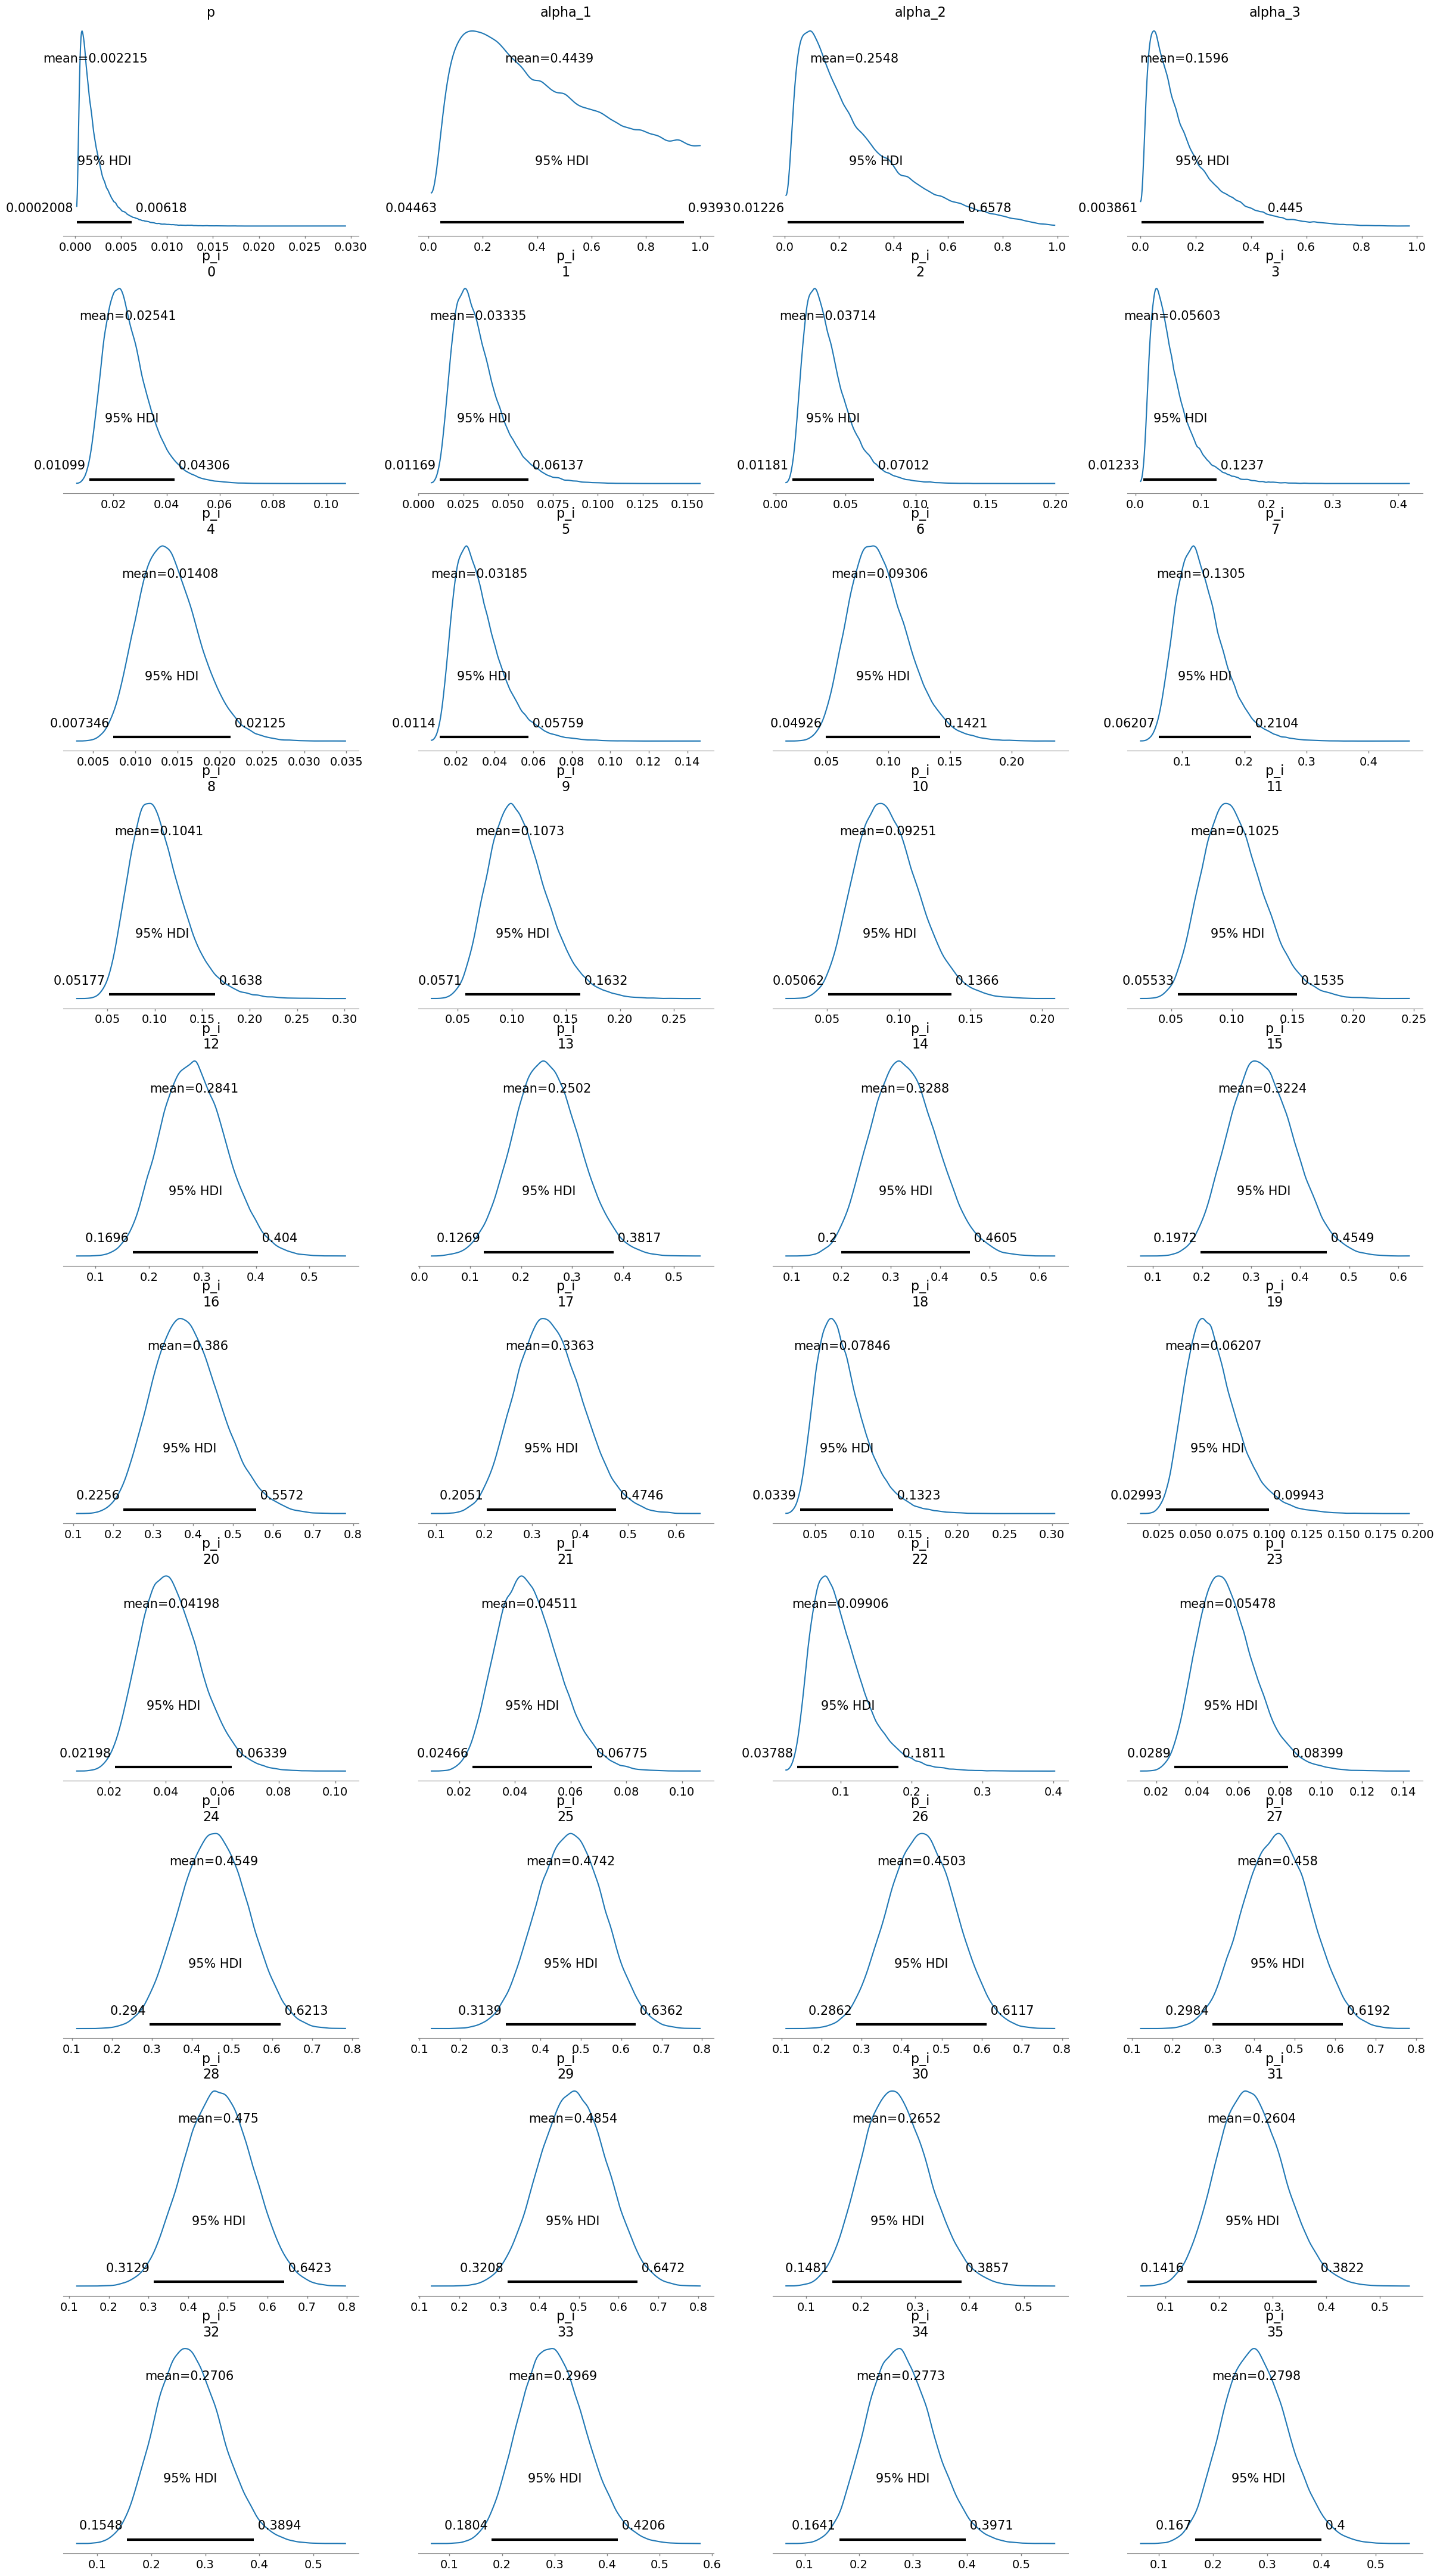

In [22]:
az.plot_posterior(trace1, round_to=4, hdi_prob=.95);

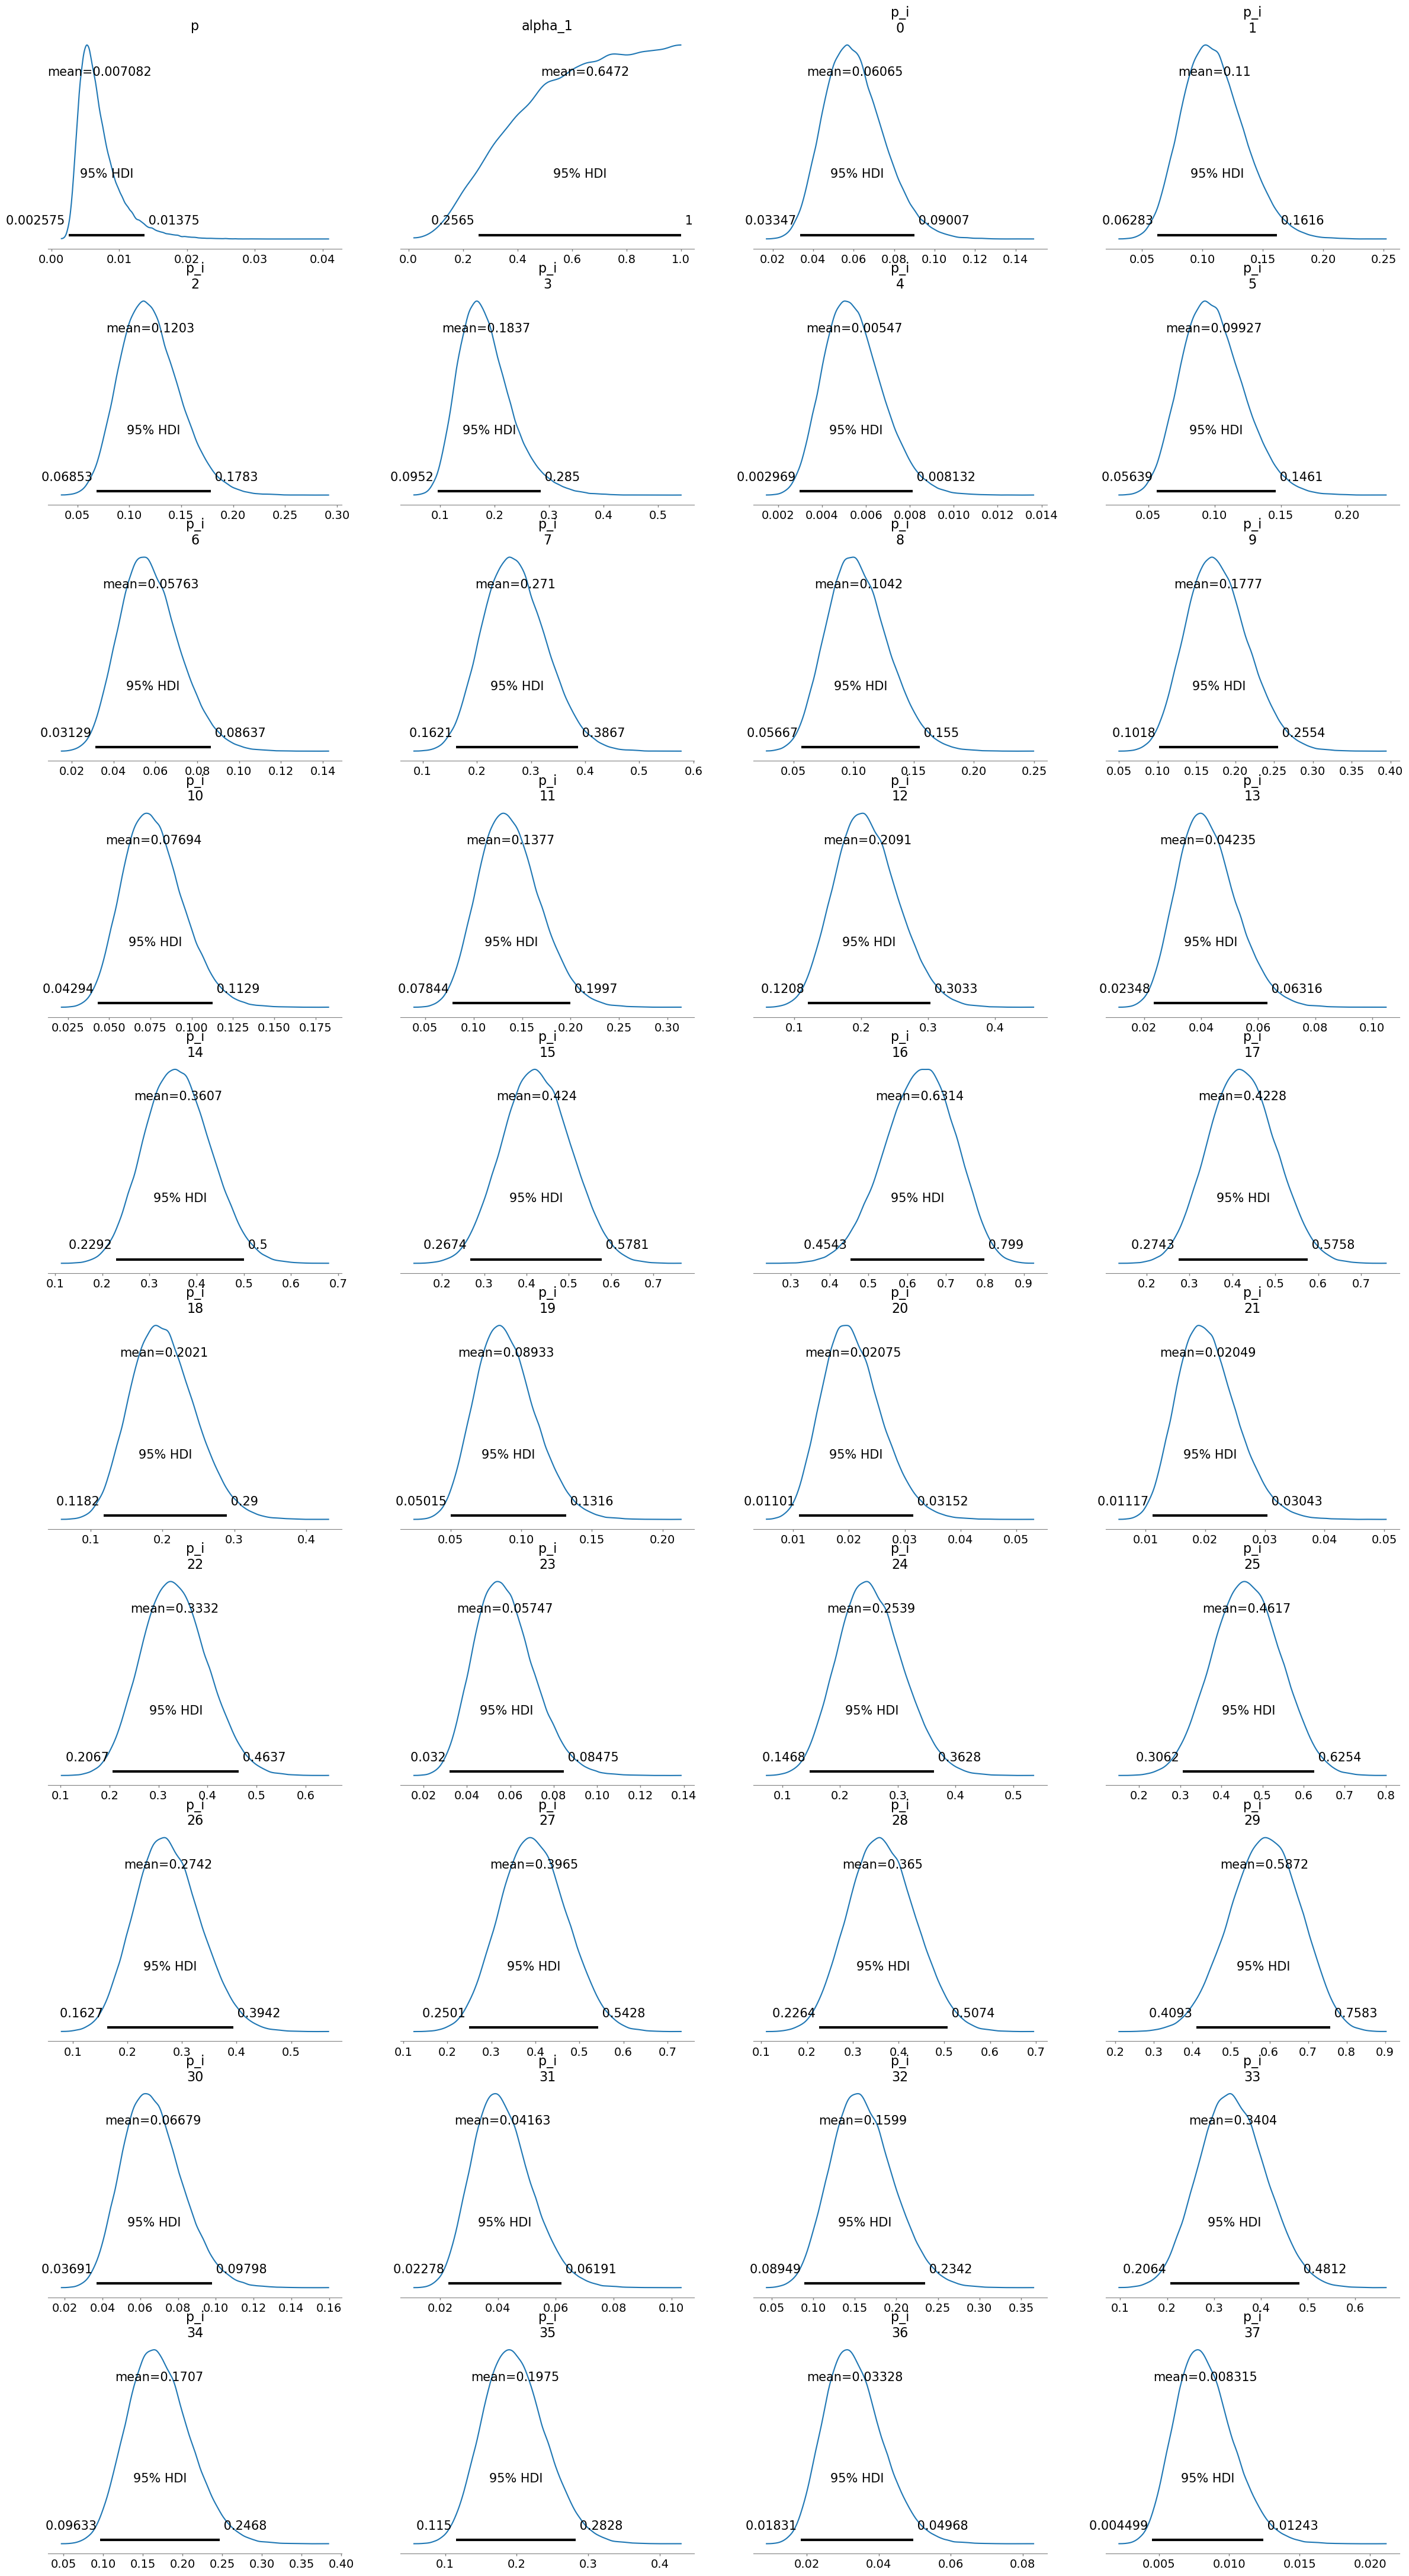

In [23]:
az.plot_posterior(trace2, round_to=4, hdi_prob=.95);

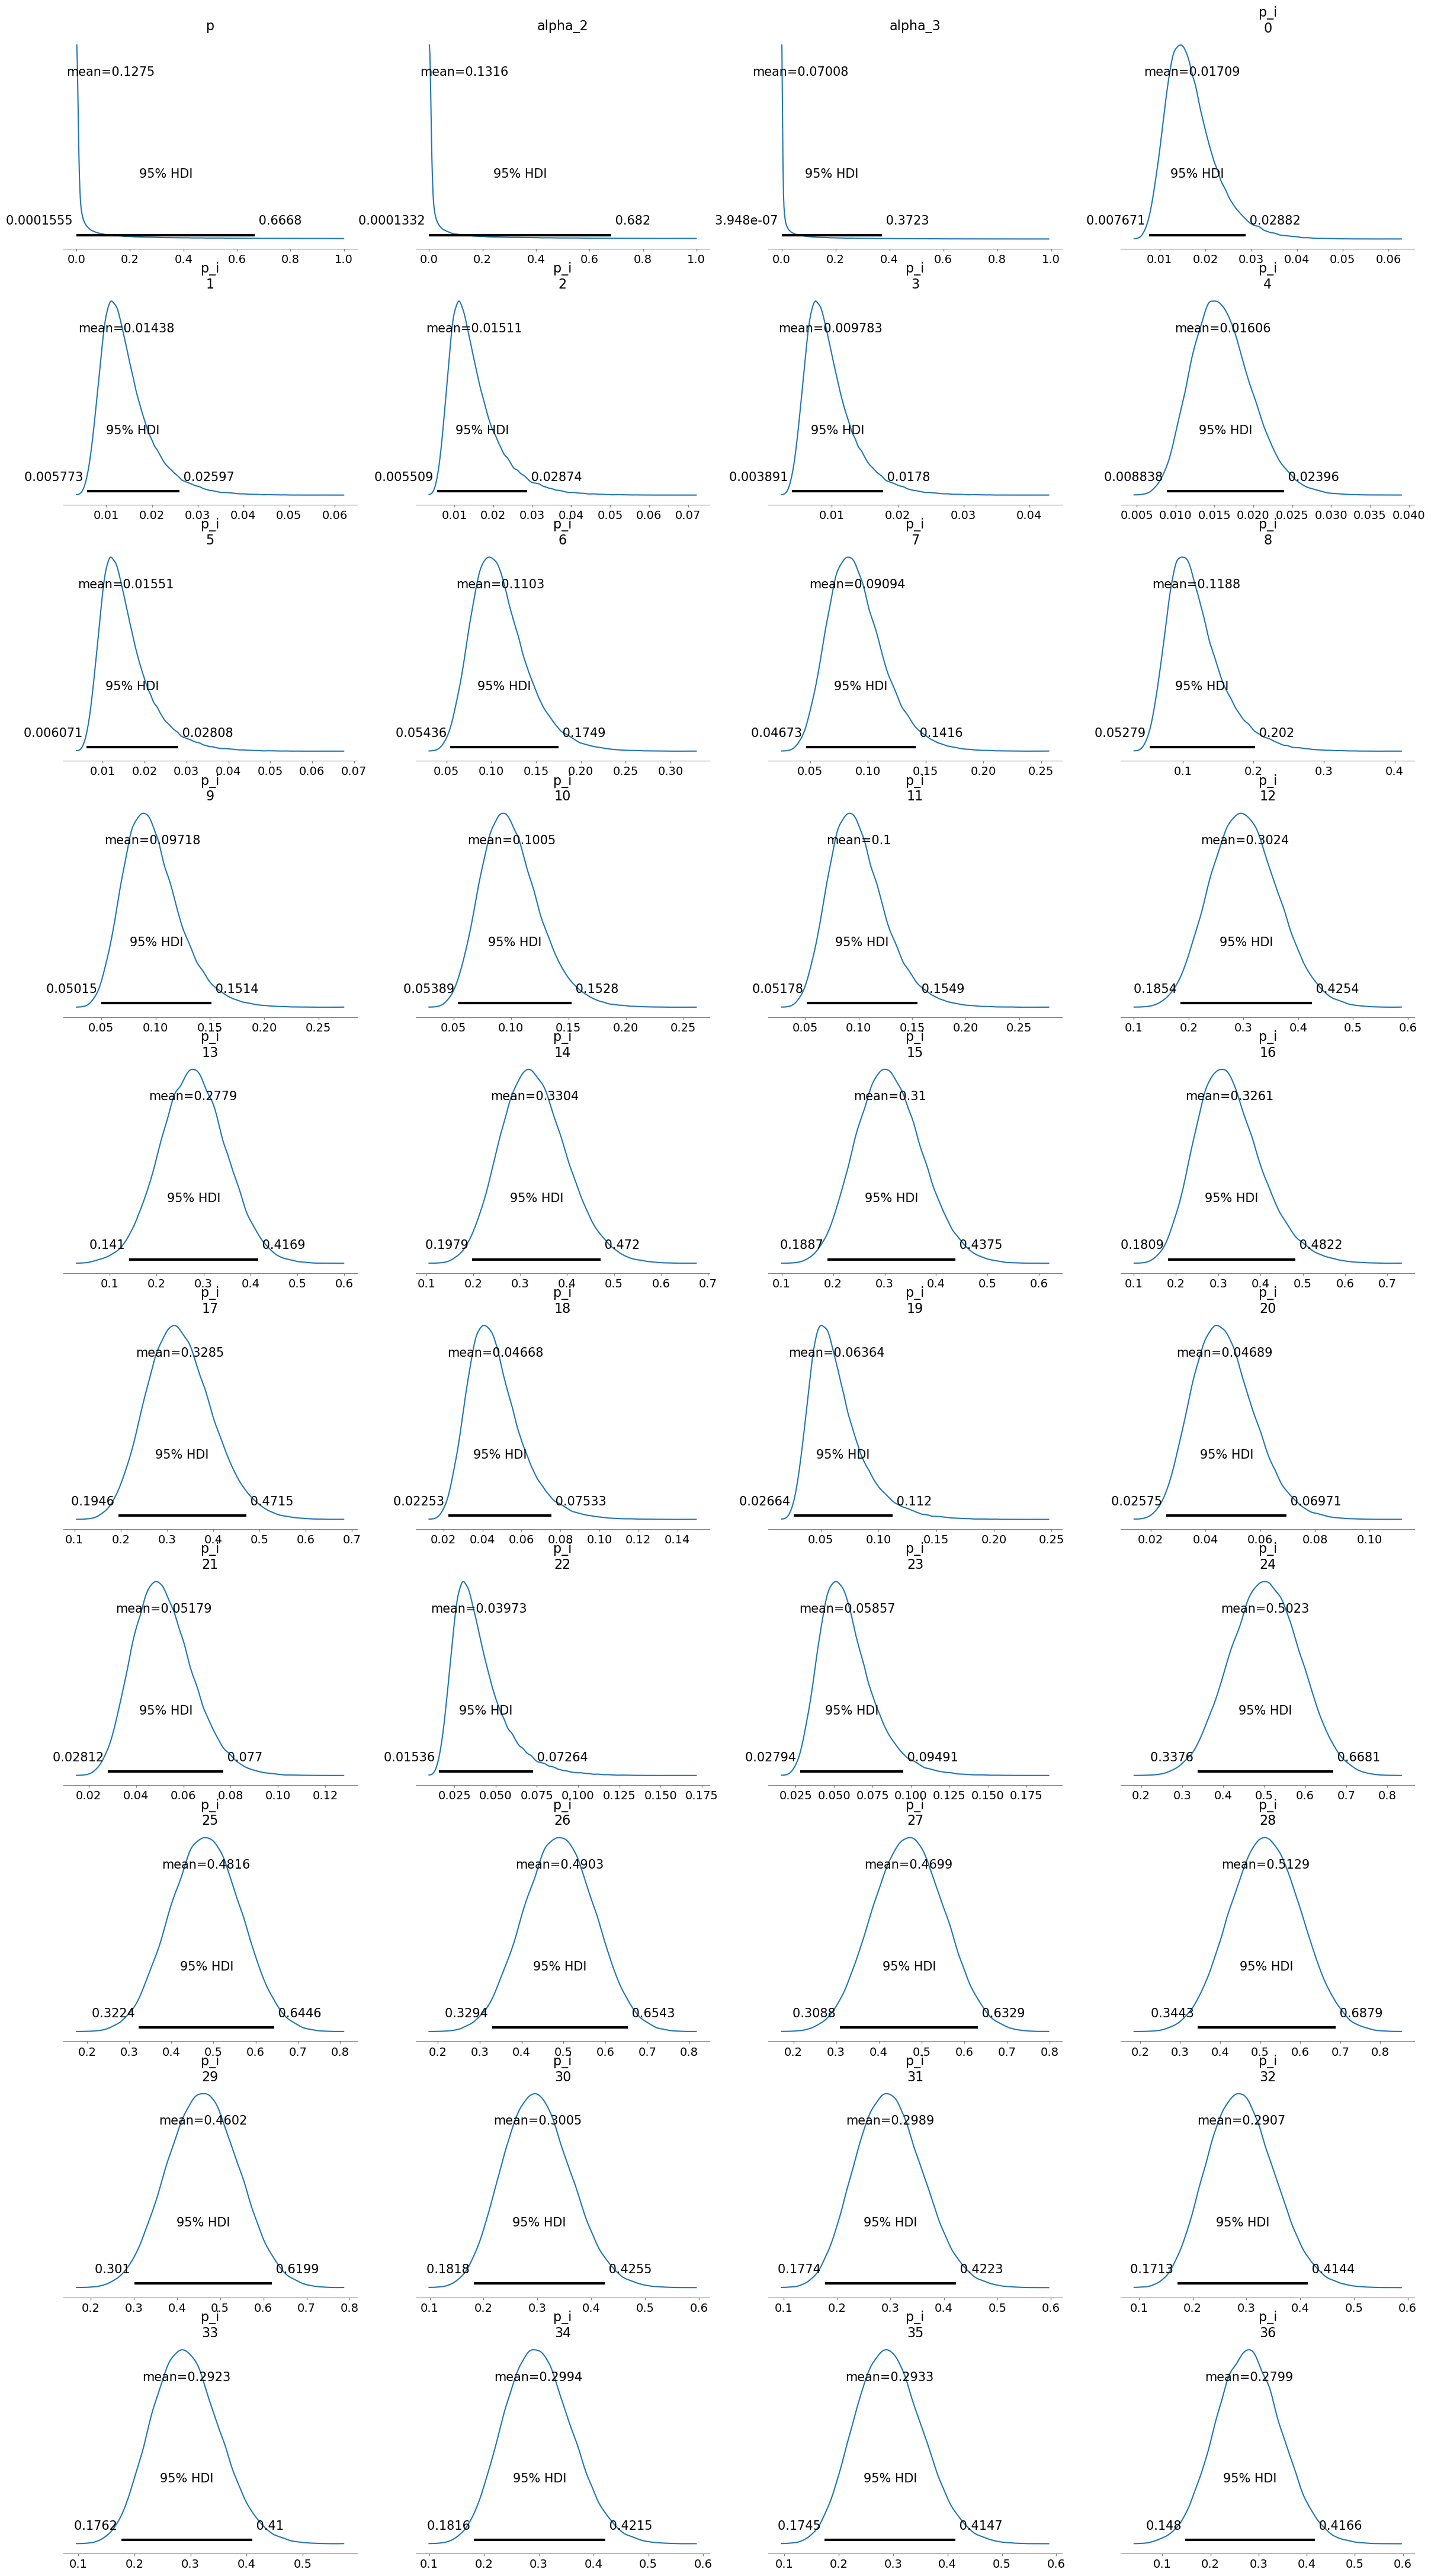

In [24]:
az.plot_posterior(trace3, round_to=4, hdi_prob=.95);

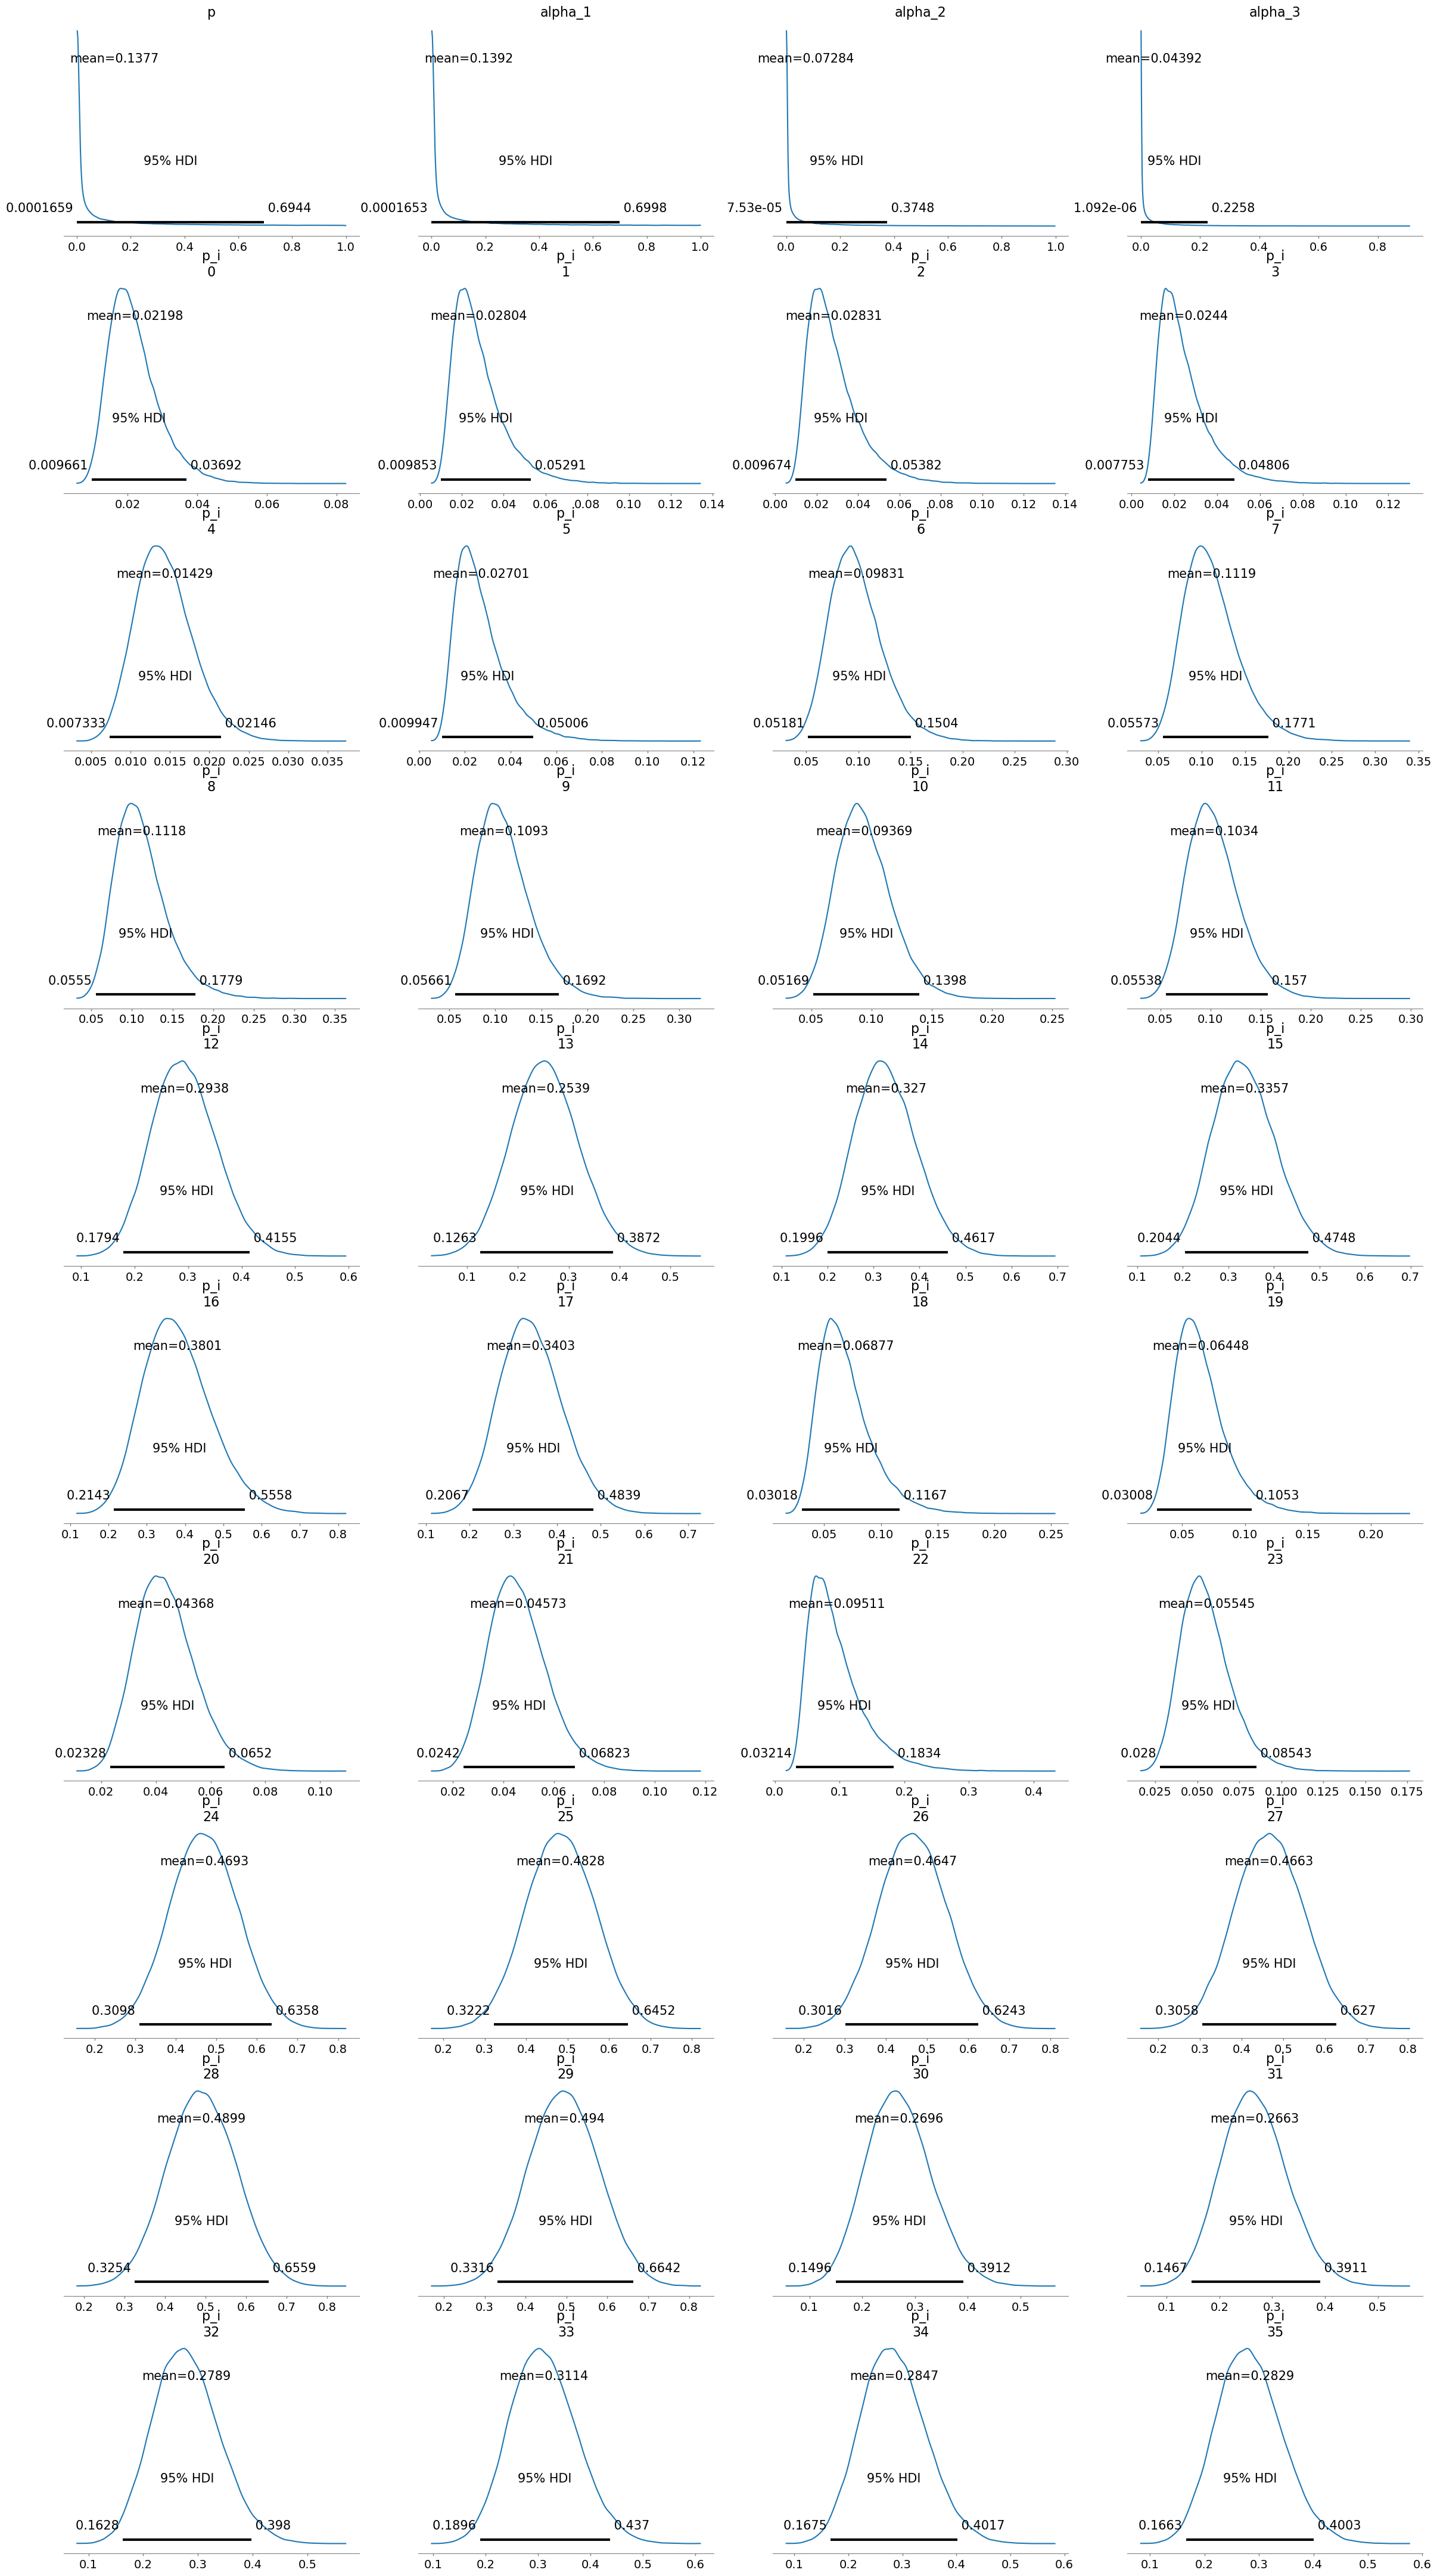

In [25]:
az.plot_posterior(trace4, round_to=4, hdi_prob=.95);

### ROC curves

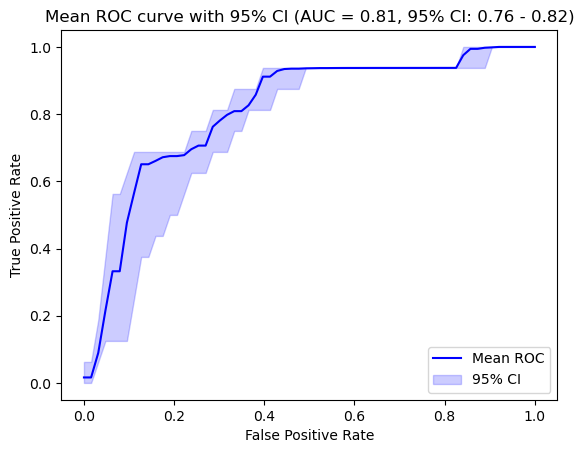

In [26]:
roc_model1 = plot_mean_roc(y, p_ind1)

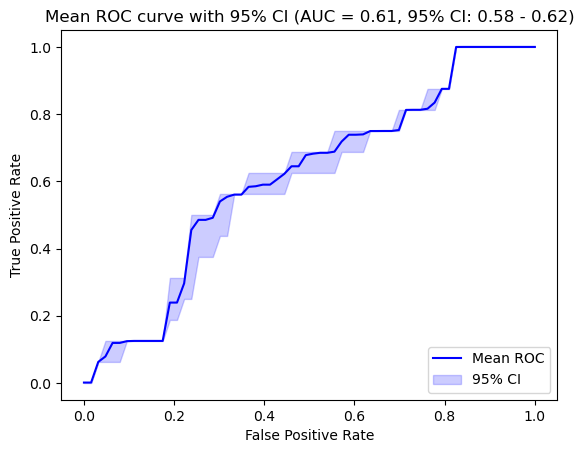

In [27]:
roc_model2 = plot_mean_roc(y, p_ind2)

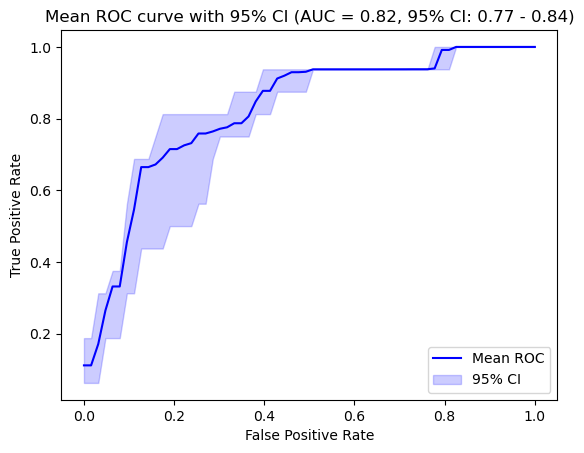

In [28]:
roc_model3 = plot_mean_roc(y, p_ind3)

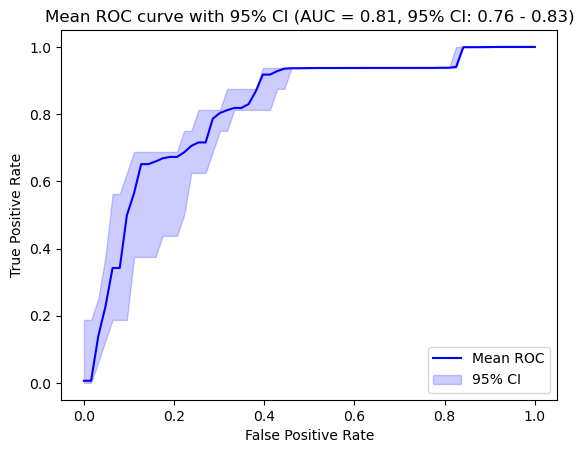

In [29]:
roc_model4 = plot_mean_roc(y, p_ind4)

### Confusion matrices

In [ ]:
cm_model1 = calculate_mean_confusion_matrix(y, p_ind1, threshold=0.5)

In [ ]:
cm_model2 = calculate_mean_confusion_matrix(y, p_ind2, threshold=0.5)

In [ ]:
cm_model3 = calculate_mean_confusion_matrix(y, p_ind3, threshold=0.5)

In [ ]:
cm_model4 = calculate_mean_confusion_matrix(y, p_ind4, threshold=0.5)

## Model comparisons

### Model comparison: AIC & BIC 

In [30]:
aic_model1, bic_model1 = calculate_aic_bic(trace1, model1, y)
print(f'AIC for model 1 (all features): {aic_model1}')
print(f'BIC for model 1 (all features): {bic_model1}')

AIC for model 1 (all features): 8.929465728556018
BIC for model 1 (all features): 17.564998061994704


In [31]:
aic_model2, bic_model2 = calculate_aic_bic(trace2, model2, y)
print(f'AIC for model 2 : {aic_model2}')
print(f'BIC for model 2 : {bic_model2}')

AIC for model 2 : 5.284310171358879
BIC for model 2 : 9.602076338078222


In [32]:
aic_model3, bic_model3 = calculate_aic_bic(trace3, model3, y)
print(f'AIC for model 3 : {aic_model3}')
print(f'BIC for model 3 : {bic_model3}')

AIC for model 3 : 6.899335851280637
BIC for model 3 : 13.375985101359651


In [33]:
aic_model4, bic_model4 = calculate_aic_bic(trace4, model4, y)
print(f'AIC for model 4 : {aic_model4}')
print(f'BIC for model 4 : {bic_model4}')

AIC for model 4 : 8.91781635786298
BIC for model 4 : 17.553348691301668


### Model comparison: Widely Applicable Information Criterion (WAIC)

In [36]:
waic1 = pm.stats.waic(trace1, model1)
waic1

Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -30.39     3.85
p_waic        1.24        -

In [38]:
waic2 = pm.stats.waic(trace2, model2)
waic2

Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -41.99     7.00
p_waic        1.68        -

There has been a warning during the calculation. Please check the results.

In [39]:
waic3 = pm.stats.waic(trace3, model3)
waic3

Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -29.33     3.67
p_waic        1.07        -

In [40]:
waic4 = pm.stats.waic(trace4, model4)
waic4

Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -29.97     3.77
p_waic        1.16        -

### Model comparison: Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV)

In [48]:
models = {
    "model1": trace1,
    "model2": trace2,
    "model3": trace3,
    "model4": trace4,
}
model_compare_default = az.compare(models)
model_compare_default

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model3,0,-29.331286,1.074903,0.000000,1.000000e+00,3.674550,0.000000,False,log
model4,1,-29.974410,1.163255,0.643125,1.918465e-13,3.769096,0.542568,False,log
model1,2,-30.397459,1.247501,1.066174,1.483258e-13,3.855822,0.807364,False,log
model2,3,-42.006868,1.701629,12.675582,0.000000e+00,7.006124,5.272672,False,log


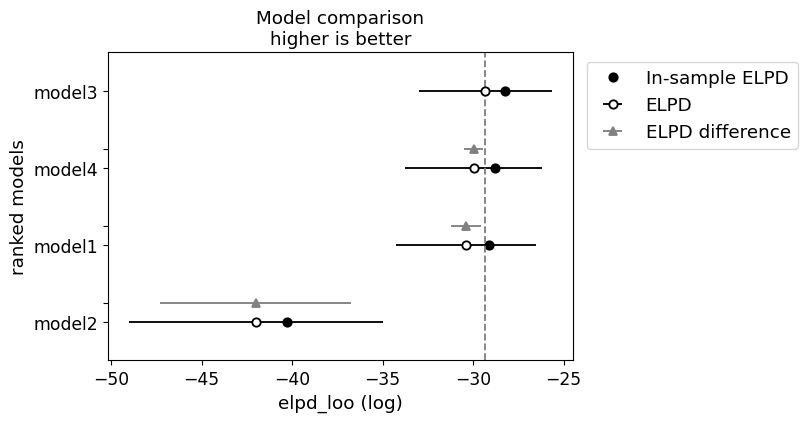

In [51]:
az.plot_compare(model_compare_default, insample_dev=True);

In [56]:
model_compare_waic = az.compare(models, ic='waic', method='BB-pseudo-BMA', b_samples=1000)
model_compare_waic

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model3,0,-29.329812,1.073429,0.000000,0.526272,3.844553,0.000000,False,log
model4,1,-29.970563,1.159408,0.640751,0.275158,7.088876,0.541387,False,log
model1,2,-30.389880,1.239921,1.060067,0.197064,3.635525,0.803351,False,log
model2,3,-41.989492,1.684253,12.659680,0.001506,3.750012,5.265315,True,log


In [57]:
model_compare_loo = az.compare(models, ic='loo', method='BB-pseudo-BMA', b_samples=1000)
model_compare_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model3,0,-29.331286,1.074903,0.000000,0.521204,3.756735,0.000000,False,log
model4,1,-29.974410,1.163255,0.643125,0.278258,6.804908,0.542568,False,log
model1,2,-30.397459,1.247501,1.066174,0.199381,3.588860,0.807364,False,log
model2,3,-42.006868,1.701629,12.675582,0.001158,3.679542,5.272672,False,log


### Classification report: F1 score

In [58]:
f1_model1 = calculate_mean_f1(y, p_ind1, threshold=0.5)

Mean F1 Score: 0.29


In [59]:
f1_model2 = calculate_mean_f1(y, p_ind2, threshold=0.5)

Mean F1 Score: 0.17


In [60]:
f1_model3 = calculate_mean_f1(y, p_ind3, threshold=0.5)

Mean F1 Score: 0.31


In [61]:
f1_model4 = calculate_mean_f1(y, p_ind4, threshold=0.5)

Mean F1 Score: 0.29


### Saving models' traces

In [62]:
with open('trace_model1.pkl', 'wb') as f:
    pickle.dump(trace1, f)

with open('trace_model2.pkl', 'wb') as f:
    pickle.dump(trace2, f)

with open('trace_model3.pkl', 'wb') as f:
    pickle.dump(trace3, f)

with open('trace_model4.pkl', 'wb') as f:
    pickle.dump(trace4, f)